In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

# import image and label

In [25]:
nSign = 3
img = cv2.imread("DTUSignPhotos/DTUSigns{0:03d}.jpg".format(nSign))
landmark = np.loadtxt("DTUSignPhotos/DTUSigns{0:03d}.txt".format(nSign))

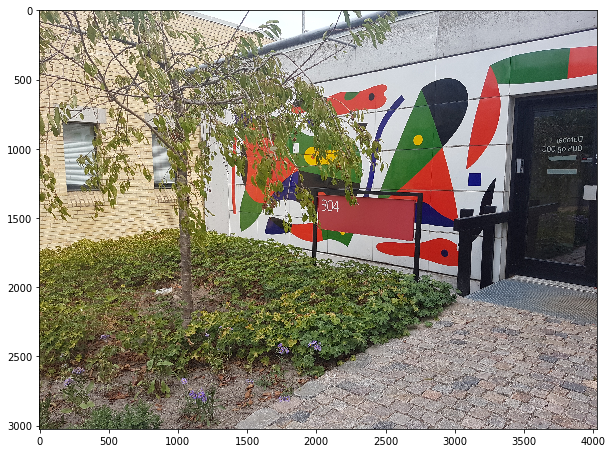

In [26]:
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.figure(figsize = (10,10))
plt.imshow(img)

(3024, 4032)


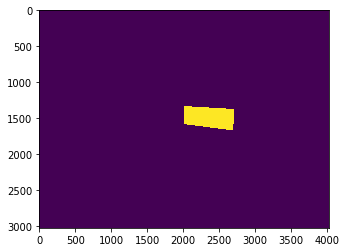

In [27]:
h,w,d = img.shape
label = np.zeros(shape = (h,w),dtype='int8')
nSquares = len(landmark)//4
for n in range(nSquares):
    idx = n*4
    cv2.fillConvexPoly(label, np.array(landmark[idx:idx+4], 'int32'), n+1)
print(label.shape) 
plt.imshow(label)

# pixel classification

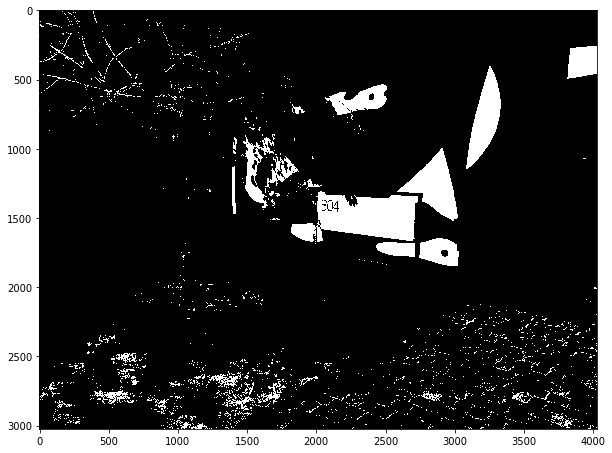

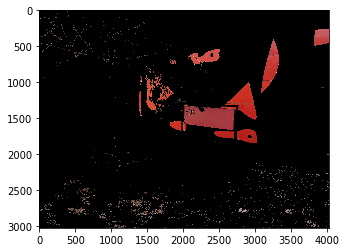

In [28]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_hsv = np.array([0, 43, 46])
upper_hsv = np.array([10, 255, 255])
mask1 = cv2.inRange(img_hsv, lowerb=lower_hsv, upperb=upper_hsv)

lower_hsv = np.array([170, 43, 46])
upper_hsv = np.array([180, 255, 255])
mask2 = cv2.inRange(img_hsv, lowerb=lower_hsv, upperb=upper_hsv)

mask = mask1+mask2
img_with_mask = cv2.bitwise_and(img,img, mask= mask)

plt.figure(figsize = (10,10))
plt.imshow(mask, cmap='gray')
plt.figure()
plt.imshow(img_with_mask)

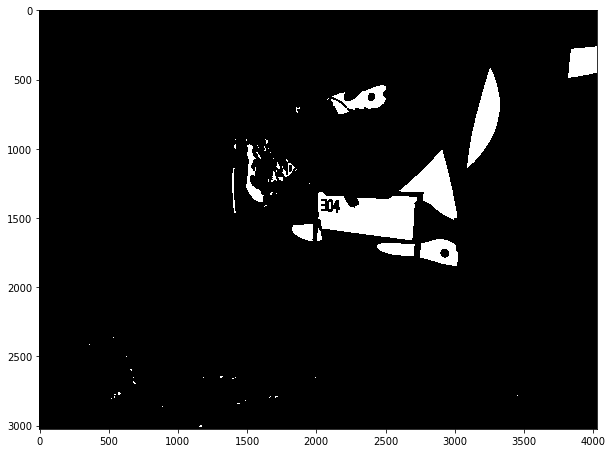

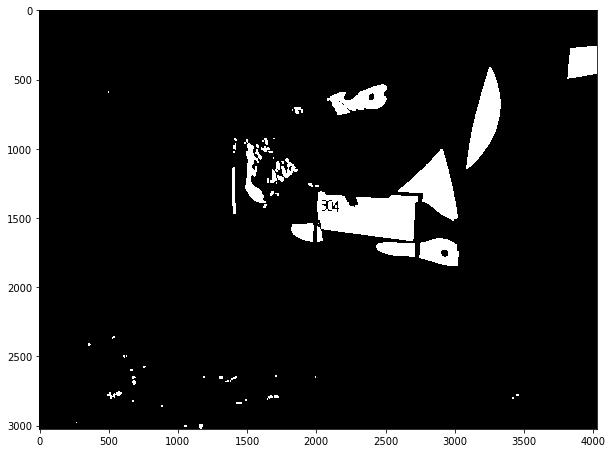

In [29]:
kernel = np.ones((3,3),np.uint8)
mask_erode =cv2.erode(mask, kernel, iterations = 5)
mask_dilate =cv2.dilate(mask_erode, kernel, iterations = 5)

plt.figure(figsize = (10,10))
plt.imshow(mask_erode, cmap='gray')
plt.figure(figsize = (10,10))
plt.imshow(mask_dilate, cmap='gray')

# BLOB analysis

## method 1 

In [30]:
cnts=cv2.findContours(mask_dilate.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #CHAIN_APPROX_NONE
cnts = imutils.grab_contours(cnts)
print(len(cnts))

72


3


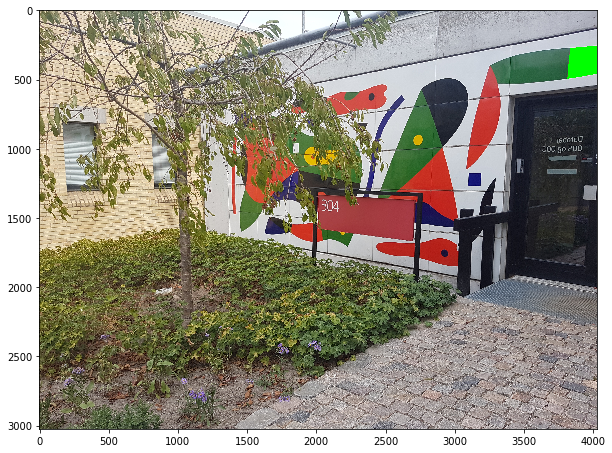

In [41]:
# filter by area and shape
signs = []
# for cnt in cnts:
#     area = cv2.contourArea(cnt)
#     if area > 15000:
#         signs.append(cnt)
        
# print(len(signs))          
# output = cv2.drawContours(img.copy(),signs,-1,(0,255,0),-1)

# x,y,w,h = cv2.boundingRect(cnt)
# img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

for cnt in cnts:
    hull = cv2.convexHull(cnt)
    epsilon = 0.1 *cv2.arcLength(hull,True)
    approx = cv2.approxPolyDP(hull, epsilon, True) 
    area = cv2.contourArea(cnt)
    if area > 15000 and len(approx)==4:
        signs.append(cnt)
        output = cv2.drawContours(img.copy(),[cnt],0,(0,255,0),-1)
        
print(len(signs))

plt.figure(figsize = (10,10))
plt.imshow(output)

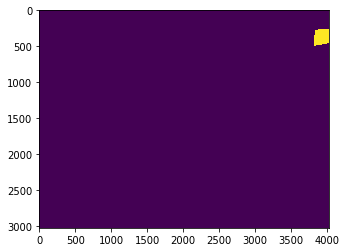

In [40]:
h,w,d = img.shape
myLabel = np.zeros(shape = (h,w),dtype='int8')

for i,s in enumerate(signs):
    cv2.fillConvexPoly(myLabel, s, i+1)
    
plt.imshow(myLabel)

## method 2

In [126]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Filter by Area.
params.filterByArea = True
params.minArea = 2000

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01


In [84]:
# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
thresh=cv2.bitwise_not(thresh)
keypoints = detector.detect(thresh)
thresh=cv2.bitwise_not(thresh)
print(len(keypoints))

NameError: name 'thresh' is not defined

In [ ]:

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
cv2.imshow('keypoint',im_with_keypoints)

# performance evaluation

In [127]:
def CombinedDiceScore(output, label):
    nLabel = np.amax(label)
    nOutput = np.amax(output)
    SumScore = 0
    nScores = 0
    
    # run through all label
    for i in range(1,nLabel+1):
        maxScore = 0
        maxIdx = -1
        labelMask = (label ==i)
        
        # find the output with maximum dice score compare to label
        for j in range(1,nOutput+1):
            outputMask = (output == j)
            score = DiceScore(labelMask, outputMask)
            if score>maxScore:
                maxScore = score
                maxIdx = j
                
        # remove the found label that already been used
        if maxIdx>0:
            output[np.where(output==maxIdx)] = 0 # find python functions
            
        SumScore += maxScore
        nScores = nScores +1
    
    DSC = 0
    if nScores>0:
        DSC = SumScore/nScores
        
    return DSC

In [128]:
def DiceScore(output, label):
    AOutput = np.sum(output)
    ALabel = np.sum(label)
    
    I = output & label
   
    ACom = np.sum(I)
    #resT = 2*abs(output-I) + abs(label - I)
    
    DSC = 2*ACom/(AOutput +ALabel)
    
    return DSC

In [129]:
CombinedDiceScore(myLabel, label)

0.9729857263082565